## Import libraries

In [1]:
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
from mlrefined_libraries import convnets_library as convlib
from mlrefined_libraries import basics_library as baslib
import autograd.numpy as np
import pandas as pd
import cv2
import csv
import pickle
import glob
import time
from scipy import signal as sig
from sklearn.preprocessing import normalize

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## load data

In [2]:
 def load_data(csvname):
    # load in data
    data = np.asarray(pd.read_csv(csvname))

    # import data and reshape appropriately
    X = data[:,0:-1]
    y = data[:,-1]
    y.shape = (len(y),1)
    
    X_square = np.zeros((len(y),28,28))
    for i in range(0,len(y)):
        X_square[i,:,:] = np.reshape(X[i,:],(28,28),1)
    
    # pad data with ones for more compact gradient computation
    o = np.ones((np.shape(X)[0],1))
    X = np.concatenate((o,X),axis = 1)
    X = X.T
    
    return X,X_square,y

In [3]:
# load data
X, X_square, y = load_data('../../mlrefined_datasets/convnet_datasets/feat_face_data.csv')
# X: all images (vectorized)
# X_square: all images (square)
# y: all labels (-1/+1)

## Plot data

<IPython.core.display.Javascript object>


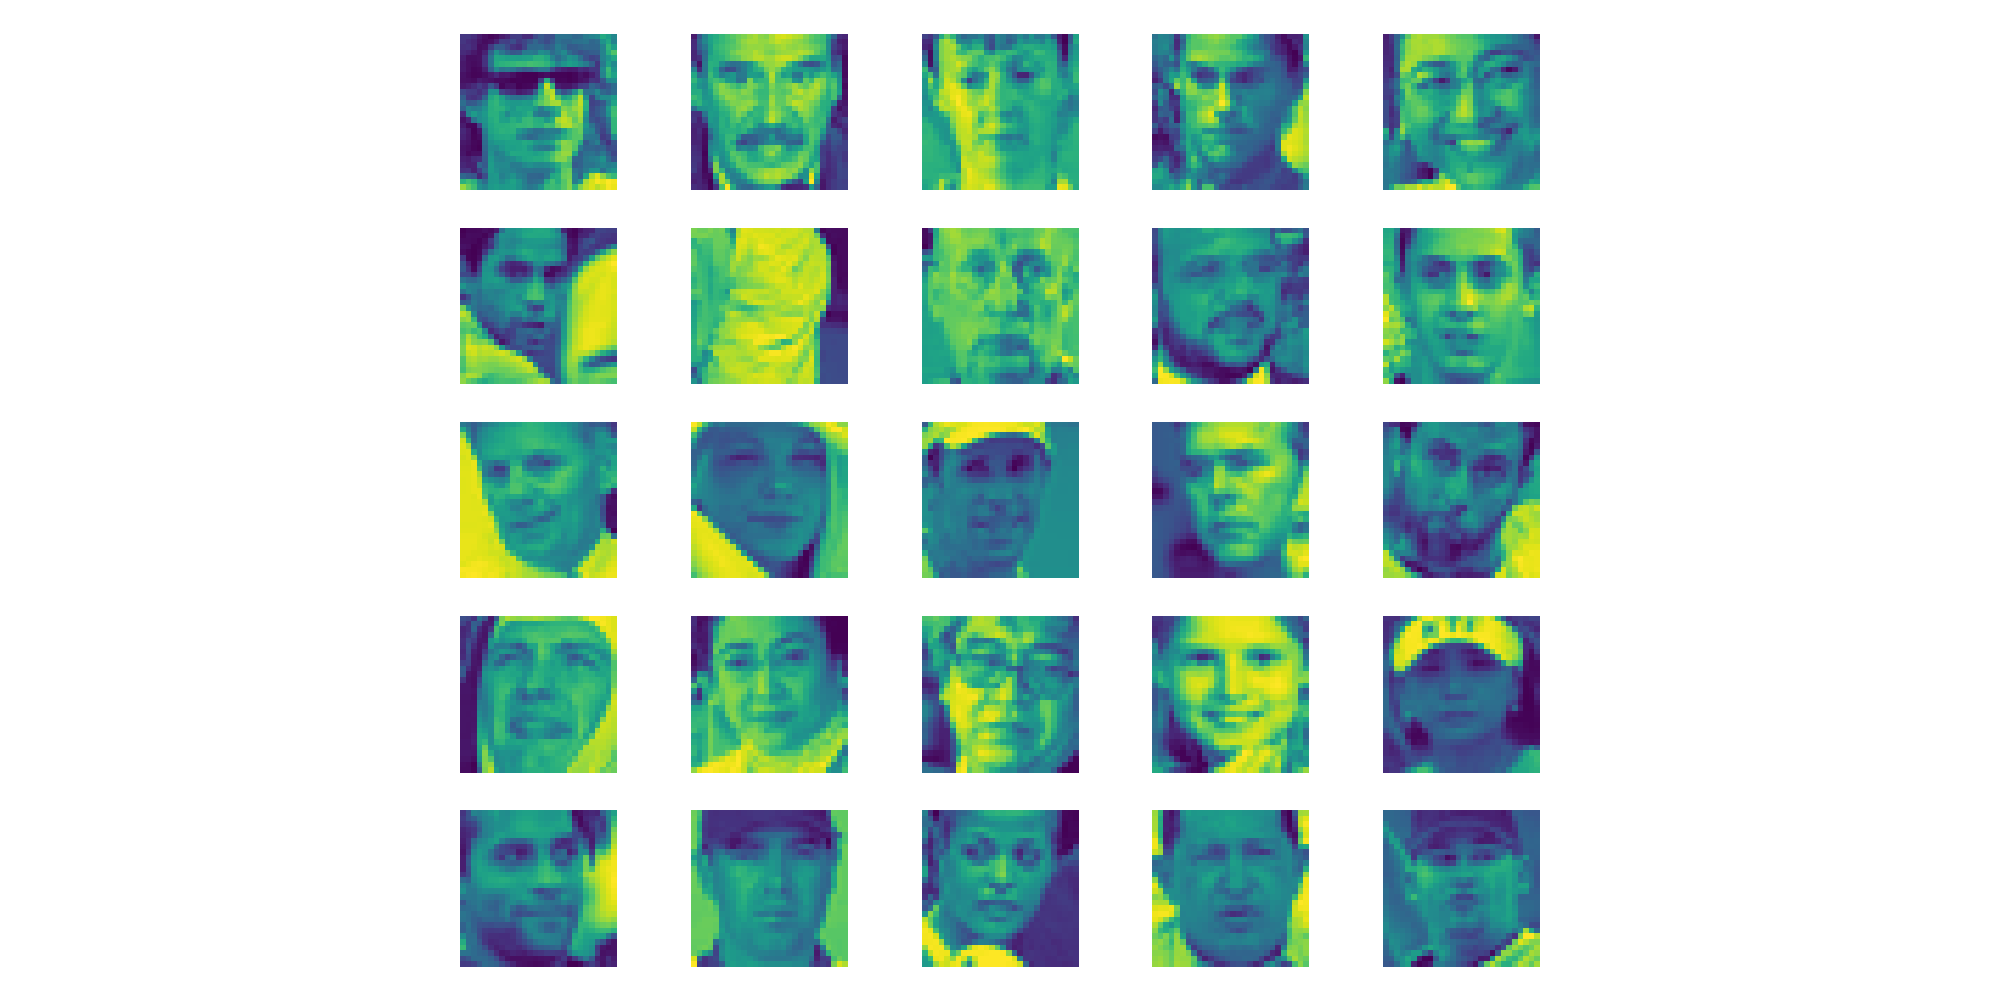

In [23]:
plt.figure(figsize=(10,5))
for i in range(1000,1025):
    plt.subplot(5,5,i+1-1000)
    plt.imshow(X_square[i,:,:])
    plt.xticks([]), plt.yticks([])
    plt.axis('off')
    plt.show()

<IPython.core.display.Javascript object>


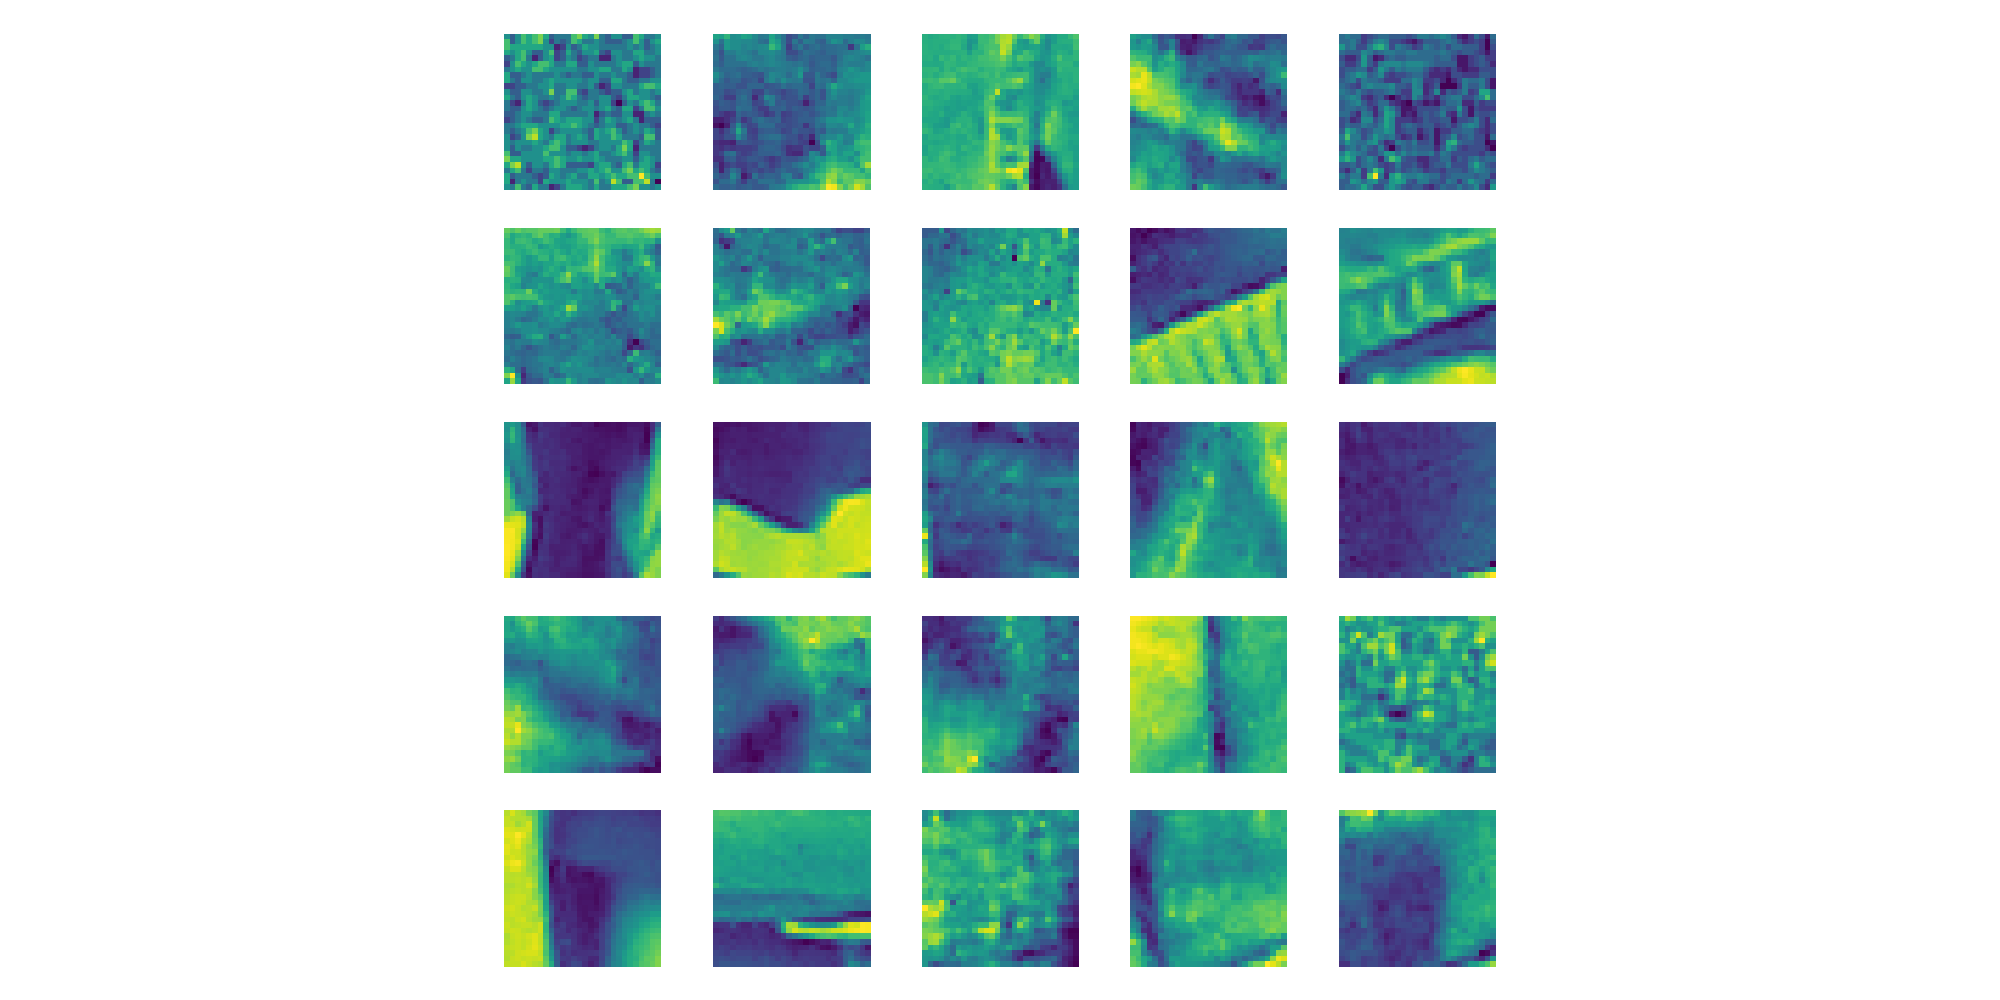

In [5]:
plt.figure(figsize=(10,5))
for i in range(9000,9025):
    plt.subplot(5,5,i+1-9000)
    plt.imshow(X_square[i,:,:])
    plt.xticks([]), plt.yticks([])
    plt.axis('off')
    plt.show()

## Sub-functions required for extracting features

In [6]:
def load_kernels(mode, **kwargs):
    
    if mode == 'random':
        kernels = {}
        num_kernels = kwargs['num_kernels']
        kernel_size = kwargs['kernel_size']

        for i in np.arange(1,num_kernels+1):
            kernels[str(i)] = np.random.randn(kernel_size[0], kernel_size[1]) 
        
    
    
    if mode == 'fixed':      
        
        kernels = {'1': np.array([[-1,  0,  1],
                              [-1,  0,  1],
                              [-1,  0,  1]]),
           
               '2': np.array([[ 0,  1,  1],
                              [-1,  0,  1],
                              [-1, -1,  0]]),
               
               '3': np.array([[ 1,  1,  1],
                              [ 0,  0,  0],
                              [-1, -1, -1]]),
           
               '4': np.array([[ 1,  1,  0],
                              [ 1,  0, -1],
                              [ 0, -1, -1]]),
           
               '5': np.array([[ 1,  0, -1],
                              [ 1,  0, -1],
                              [ 1,  0, -1]]),
                       
               '6': np.array([[ 0, -1, -1],
                              [ 1,  0, -1],
                              [ 1,  1,  0]]),
               
               '7': np.array([[-1, -1, -1],
                              [ 0,  0,  0],
                              [ 1,  1,  1]]),
           
               '8': np.array([[-1, -1,  0],
                              [-1,  0,  1],
                              [ 0,  1,  1]])}        
        
    return kernels

In [94]:
def ScipyConv(image, kernel):
    # flip kernel
    kernel = np.flipud(np.fliplr(kernel))
    
    # compute convolution
    conv = sig.convolve2d(image, kernel, boundary='fill', fillvalue=0, mode='same')
    return conv    

In [122]:
def myRepeatPadding(img, kernel_size):
            
    # add top and bottom paddings
    L1 = int((kernel_size[0]-1)/2) 
    top = np.repeat(np.reshape(img[0,:],(1,-1)), L1, axis=0)
    bottom = np.repeat(np.reshape(img[-1,:],(1,-1)), L1, axis=0)
    img = np.concatenate((top,img),0)
    img = np.concatenate((img,bottom),0)
            
    # add left and right paddings     
    L2 = int((kernel_size[1]-1)/2) 
    left = np.repeat(np.reshape(img[:,0],(-1,1)), L2, axis=1)
    right = np.repeat(np.reshape(img[:,-1],(-1,1)), L2, axis=1)
    img = np.concatenate((left,img),1)
    img = np.concatenate((img,right),1)
   
    return img

In [123]:
def myZeroPadding(img, kernel_size):
            
    # add top and bottom paddings
    L1 = int((kernel_size[0]-1)/2) 
    top_bottom = np.zeros((L1, np.shape(img)[1]))
    img = np.concatenate((top_bottom,img),0)
    img = np.concatenate((img,top_bottom),0)
            
    # add left and right paddings     
    L2 = int((kernel_size[1]-1)/2) 
    left_right = np.zeros((np.shape(img)[0], L2))
    img = np.concatenate((left_right, img),1)
    img = np.concatenate((img, left_right),1)
   
    return img

In [124]:
def myConv(img, kernel):
            
    N1 = np.size(img,0)
    N2 = np.size(img,1)
    L1 = np.size(kernel,0)
    L2 = np.size(kernel,1)
    
    padded_img = myZeroPadding(img, [L1, L2])
    conv_img = np.zeros((N1,N2))
    for i in range(0, N1):
        for j in range(0, N2):
            conv_img[i,j] = sum(sum(padded_img[i:i+L1, j:j+L2]*kernel))
            
    return conv_img

In [125]:
def sliding_window(image, sliding_window_size, stride):
    for i in np.arange(0, np.shape(image)[0]-sliding_window_size[0]+1, stride):
        for j in np.arange(0, np.shape(image)[1]-sliding_window_size[1]+1, stride):
            yield image[i:i+sliding_window_size[0], j:j+sliding_window_size[1]]

In [136]:
def make_feat(image, kernels, **kwargs):
    
    sliding_window_size = (3,3)
    if 'sliding_window_size' in kwargs:
        sliding_window_size = kwargs['sliding_window_size']
    
    stride = 1
    if 'stride' in kwargs:
        stride = kwargs['stride']    
    
    pooling_func = 'max'
    if 'pooling_func' in kwargs:
        pooling_func = kwargs['pooling_func']   
        
    if  pooling_func == 'max':
        pool = lambda window: window.max()   
        
    if  pooling_func == 'mean':
        pool = lambda window: window.mean()  
        
    norm = 'l2'
    if 'norm' in kwargs:
        norm = kwargs['norm']     
    
    
    feat=[]
    for ind, kernel in kernels.items():     
        
        # compute convolution
        conv = ScipyConv(image, kernel)
        
        # pooling
        conv_feats=[]
        for window in sliding_window(conv, sliding_window_size, stride):
            conv_feats.append(pool(window))
        
        feat.append(conv_feats)
    
    # normalize each patch across the filters
    feat = normalize(feat, norm=norm, axis=0)
        
    return np.reshape(feat, np.size(feat), 1)   

## Extract features

In [137]:
# load kernels
kernels = load_kernels(mode='fixed')

# params
sliding_window_size = (5,5) 
stride = 3
pooling_func = 'max'
norm = 'max'

# get number of images in the dataset
num_images = np.shape(X_square)[0]
        
# a test run to find the number of features with the params above
test = make_feat(X_square[0,:,:], kernels, sliding_window_size=sliding_window_size, stride=stride)
num_features = np.shape(test)[0]

                
feat = np.zeros((num_features,num_images))
tic = time.clock()
for i in range(0,num_images):
    # extract my features
    feat[:,i] = make_feat(X_square[i,:,:], kernels, sliding_window_size=sliding_window_size,
                                            stride=stride, pooling_func=pooling_func, norm=norm)
toc = time.clock()
print(toc-tic)
# uncomment to pad features with ones (if needed)
feat = np.concatenate((np.ones((1,num_images)),feat))

38.08422799999994


In [140]:
print('number of images: ', np.shape(y)[0])
print('number of raw pixels: ', np.shape(X)[0])
print('number of my features: ', np.shape(feat)[0])

number of images:  9999
number of raw pixels:  785
number of my features:  513


In [141]:
# split into train/test
X_train = np.concatenate((X[:,0:2000],X[:,2999:8000]),1)
feat_train = np.concatenate((feat[:,0:2000],feat[:,2999:8000]),1)
y_train = np.concatenate((y[0:2000],y[2999:8000]))

X_test = np.concatenate((X[:,2000:2999],X[:,8000:10000]),1)
feat_test = np.concatenate((feat[:,2000:2999],feat[:,8000:10000]),1)
y_test = np.concatenate((y[2000:2999],y[8000:10000]))

## Classification

In [149]:
###### for squared margin cost #######
# function for computing gradient and Hessian for squared margin cost Newton's method
def squared_margin_grad_hess(X, y, w):
    hess = 0
    grad = 0
    for p in range(0,len(y)):
        # precompute        
        x_p = X[:,p]
        y_p = y[p]
        
        # update grad and hessian
        grad+= -2*max(0,1 - y_p*np.dot(x_p.T,w))*y_p*x_p
        
        if 1 - y_p*np.dot(x_p.T,w) > 0:
            hess+= 2*np.outer(x_p,x_p)
        
    grad.shape = (len(grad),1)
    return grad,hess

# run newton's method
def squared_margin_newtons_method(X_train, y_train, w, X_test, y_test):
    # begin newton's method loop    
    max_its = 5
    misclass_history = []
    for k in range(max_its):
        # compute gradient and Hessian
        grad,hess = squared_margin_grad_hess(X_train, y_train, w)

        # take Newton step
        hess = hess + 10**-3*np.diag(np.ones((np.shape(X_train)[0])))
        temp = np.dot(hess,w) - grad        
        w = np.dot(np.linalg.pinv(hess),temp)

        # update history container
        cost = count_misclasses(w, X_test, y_test)
        misclass_history.append(cost)
        
        print('iteration:',k+1, ' of ', max_its)
    
    return misclass_history

In [132]:
# function for counting the number of misclassifications
def count_misclasses(w, X, y):
    y_pred = np.sign(np.dot(X.T,w))
    num_misclassed = len(y) - len([i for i, j in zip(y, y_pred) if i == j])
    return num_misclassed

In [133]:
###### raw pixels #######
w0 = np.random.randn(np.shape(X_train)[0],1)
squared_margin_history_raw = squared_margin_newtons_method(X_train, y_train, w0, X_test, y_test)

iteration: 1  of  5
iteration: 2  of  5
iteration: 3  of  5
iteration: 4  of  5
iteration: 5  of  5


In [150]:
###### myHOG #######
w0 = np.random.randn(np.shape(feat)[0],1)
squared_margin_history_HOG = squared_margin_newtons_method(feat_train, y_train, w0, feat_test, y_test)

iteration: 1  of  5
iteration: 2  of  5
iteration: 3  of  5
iteration: 4  of  5
iteration: 5  of  5


## Plotting the results

pixel accuracy:  91.12741827885257
myHOG accuracy:  99.16611074049366


<IPython.core.display.Javascript object>


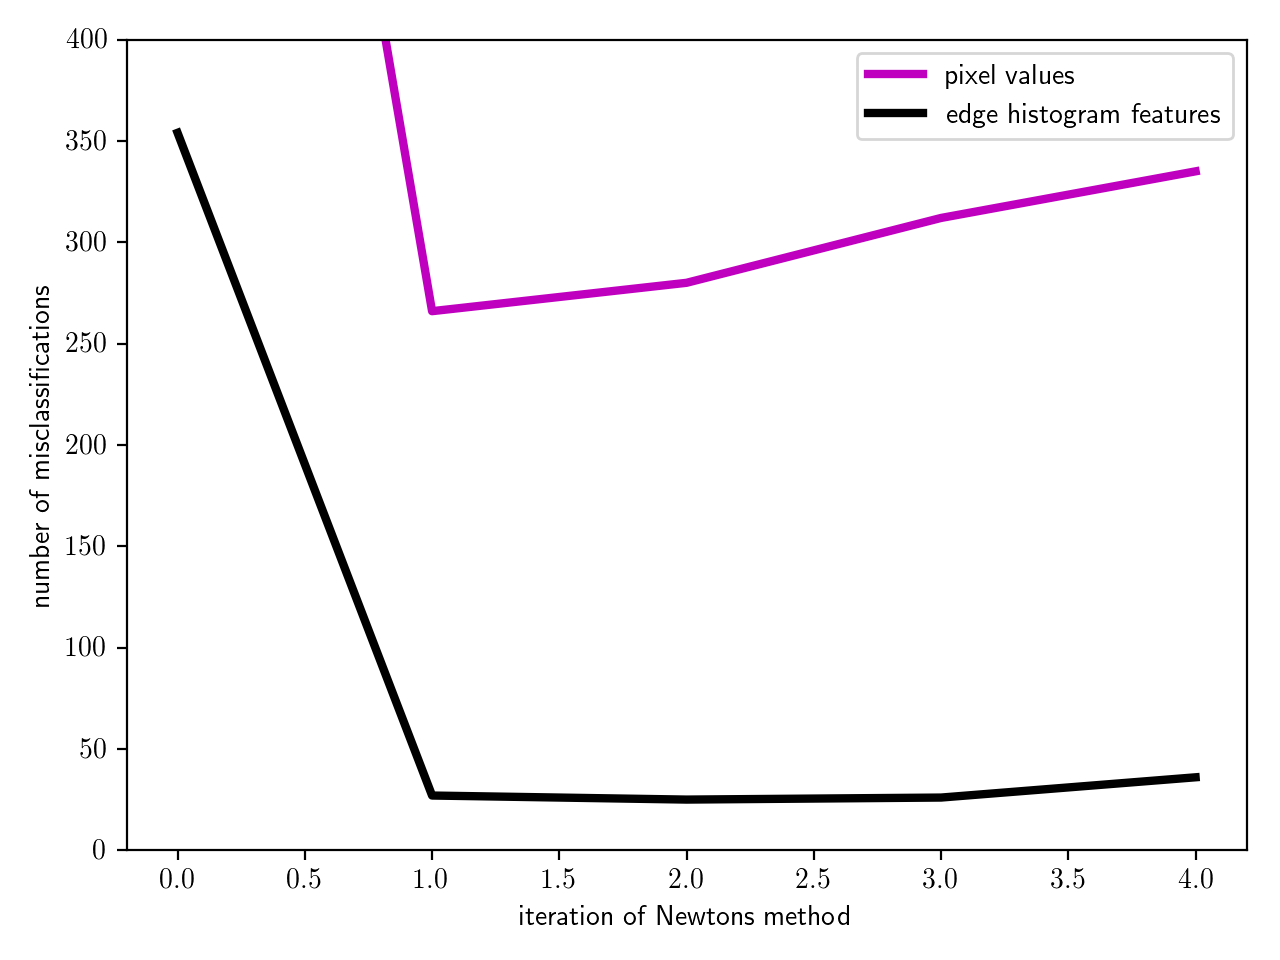

In [151]:
print('pixel accuracy: ', 100*(1-min(squared_margin_history_raw)/len(y_test)))
print('myHOG accuracy: ', 100*(1-min(squared_margin_history_HOG)/len(y_test)))

plt.figure()
# plot results
plt.plot(squared_margin_history_raw,color = 'm', linewidth=3)
plt.plot(squared_margin_history_HOG,'k', linewidth=3)

# clean up plot
plt.ylim([0,400])
plt.xlabel('iteration of Newtons method')
plt.ylabel('number of misclassifications')
plt.legend(['pixel values','edge histogram features'])
plt.show()